In [ ]:
!pip install gluonts[Prophet]

In [ ]:
!pip3 install "pystan<3"

In [ ]:
# !pip install 'rpy2>=2.9.*,<3.*'
#  R not working with this notebook kernel
# R -e 'install.packages(c("forecast", "nnfor"), repos="https://cloud.r-project.org")'

In [5]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn import metrics
import math
from pathlib import Path
import json
import os


In [6]:
from gluonts.dataset import common as gluondata
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.dataset import common as gluondata
from gluonts.evaluation import Evaluator
from gluonts.evaluation import make_evaluation_predictions
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts import model
from gluonts.mx import Trainer

from gluonts.transform import AdhocTransform

In [8]:
NUM_SAMPLES = 1000
EVAL_REPETITION = 1
NUM_REPETITION = 1

In [9]:
# for a given dataset cuts it off the last prediction_lengths steps and shuffles the
# window steps before that across the examples. 
def create_interventional_dataset(dataset, prediction_length, feature_name=None, window=1):
    one_dim_target = dataset.process.trans[1].req_ndim == 1
    freq = dataset.process.trans[0].freq

    if feature_name is None:
        assert one_dim_target
        feature_name = "target"
    all_data = list(dataset)
    num_rows = len(dataset)
    row_idxs = np.array(range(num_rows))
    np.random.shuffle(row_idxs)

    intervened_data = []
    for idx, row in enumerate(dataset):
        row = row.copy()
        # cut data off prediction length of dataset (for consistency with what input / output we use for the statistical error)
        row[feature_name] = row[feature_name][..., : -prediction_length]
        intervention = all_data[row_idxs[idx]][feature_name][..., -prediction_length-window : -prediction_length]
        row[feature_name][..., -window : ] = intervention
        intervened_data.append(row)
    return gluondata.ListDataset(intervened_data, freq, one_dim_target)


def create_interventional_same_row_dataset(dataset, prediction_length, feature_name=None, window=1):
    one_dim_target = dataset.process.trans[1].req_ndim == 1
    freq = dataset.process.trans[0].freq

    if feature_name is None:
        assert one_dim_target
        feature_name = "target"
    intervened_data = []
    for idx, row in enumerate(dataset):
        row = row.copy()
        # cut data off prediction length of dataset (for consistency with what input / output we use for the statistical error)
        row[feature_name] = row[feature_name][..., : -prediction_length]
        rnd_idx = np.random.choice(len(row[feature_name]) - window)
        intervention = row[feature_name][..., rnd_idx : rnd_idx + window]
        row[feature_name][..., -window : ] = intervention
        intervened_data.append(row)
    return gluondata.ListDataset(intervened_data, freq, one_dim_target)
   

In [10]:

def eval_rmse(forecast1, forecast2, omega=1):
    f1_at_omega = [f.mean[omega] for f in forecast1]
    f2_at_omega = [f.mean[omega] for f in forecast2]
    return math.sqrt(metrics.mean_squared_error(f1_at_omega, f2_at_omega))


def eval_predictor(predictor, dataset):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,  # test dataset
        predictor=predictor,  # predictor
        num_samples=NUM_SAMPLES,
    )
    forecast_it = list(forecast_it)
    ts_it = list(ts_it)
    evaluator = Evaluator()
    agg_metrics, _ = evaluator(ts_it, forecast_it, num_series=len(dataset.test))
    rmse = agg_metrics["RMSE"]
    return forecast_it, rmse, uncertainty_prediction(forecast_it)


def uncertainty_prediction(forecast):
    CI_width = []
    for entry in forecast:
        CI_width.append(np.mean(np.absolute(entry.quantile(0.9) - entry.quantile(0.1))))
    return np.mean(CI_width)

def compare(predictor1, predictor2, dataset, dataset_intervened1, dataset_intervened2):
    forecast_it1, rmse1, uncertainty1 = eval_predictor(predictor1, dataset)
    forecast_it2, rmse2, uncertainty2 = eval_predictor(predictor2, dataset)
    disagreement = eval_rmse(forecast_it1, forecast_it2)
    
    results = {
        "RMSE1": rmse1,
        "RMSE2": rmse2,
        "RMSE1vs2": disagreement,
        "80_CI_width_1": uncertainty1,
        "80_CI_width_2": uncertainty2,
    }
    
    for i, intervention in enumerate([dataset_intervened1, dataset_intervened2]):
        if intervention is None:
            continue
        forecast_intervened1 = list(predictor1.predict(intervention, num_samples=NUM_SAMPLES))
        forecast_intervened2 = list(predictor2.predict(intervention, num_samples=NUM_SAMPLES))
        intervened_disagreement = eval_rmse(forecast_intervened1, forecast_intervened2)
        uncertainty_intervened1 = uncertainty_prediction(forecast_intervened1)
        uncertainty_intervened2 = uncertainty_prediction(forecast_intervened2)
        results[f"interventional{i+1}_RMSE_pred1vs2"] = intervened_disagreement
        results[f"80_CI_width_intervened{i+1}_pred1"] = uncertainty_intervened1
        results[f"80_CI_width_intervened{i+1}_pred2"] = uncertainty_intervened2
    return {k: float(v) for (k,v) in results.items()}


## Application to a specific dataset and models

In [11]:
# length of time points we intervene on before predicting the future.
WINDOW = 1

In [12]:
dataset = get_dataset("traffic", regenerate=False)

In [13]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.wavenet import WaveNetEstimator
from gluonts.model.r_forecast import RForecastPredictor
from gluonts.model.transformer import TransformerEstimator

def make_trainer():
    return Trainer(
        ctx="cpu",
        epochs=1,
        learning_rate=1e-3,
        batch_size=32,
    )

def save_to_dir(predictor, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    predictor.serialize(Path(directory))

def make_estimators(dataset):
    return {
        "simple_ff": SimpleFeedForwardEstimator(
            prediction_length=dataset.metadata.prediction_length,
            freq=dataset.metadata.freq,
            #trainer=make_trainer(),
        ),
        "deep_ar": DeepAREstimator(
            prediction_length=dataset.metadata.prediction_length,
            freq=dataset.metadata.freq,
             #trainer=make_trainer(),
        ),
        
#         "prophet": ProphetPredictor( # find out how to train it.
#             prediction_length=dataset.metadata.prediction_length,
#             freq=dataset.metadata.freq,
#         ),
        "wavenet": WaveNetEstimator(
            prediction_length=dataset.metadata.prediction_length,
            freq=dataset.metadata.freq,
            #trainer=make_trainer(),
        ),
        "transformer": TransformerEstimator(
            prediction_length=dataset.metadata.prediction_length,
            freq=dataset.metadata.freq,
            #trainer=make_trainer(),
        ),
        # TODO: simple VAR model - don't have R here - but maybe just switch to the
        # VAR sklearn model we use in the simulations?
#         "auto_ar": RForecastPredictor(
#             prediction_length=dataset.metadata.prediction_length,
#             freq=dataset.metadata.freq,
#             method_name="arima",
#         )
    }


In [ ]:
for k, estimator in make_estimators(dataset).items():
    print(f"______________estimator {k}")
    for run_id in enumerate(NUM_REPETITIONS):
        print(f"---------- run {run_id}")
        # 1. train predictors
        predictor1 = estimator.train(dataset.train)
        predictor2 = estimator.train(dataset.train)
        save_to_dir(predictor1, f"models/{k}_1_run{run_id}")
        save_to_dir(predictor2, f"models/{k}_2_run{run_id}")
        print("saved")
        # 2. create interventional dataset
        dataset_intervened = create_interventional_dataset(
            dataset.test, predictor1.prediction_length, window=WINDOW)
        dataset_intervened2 = create_interventional_same_row_dataset(
            dataset.test, predictor1.prediction_length, feature_name=None, window=WINDOW)
        # 3. eval predictors
        print("eval")
        res = {}
        for i in range(EVAL_REPETITION):
            res[f"repetition_{i}"] = compare(
                predictor1, predictor2, dataset, dataset_intervened, dataset_intervened2)
        with open(f"results/{k}_run{run_id}_results.json", 'w', encoding='utf-8') as f:
            json.dump(res, f, ensure_ascii=False, indent=4)

In [41]:
NUM_SAMPLES = 100
print(compare(predictor1, predictor2, dataset, dataset_intervened, dataset_intervened2))
print(compare(predictor1, predictor2, dataset, dataset_intervened, dataset_intervened2))

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 2539.96it/s]


{'RMSE1': 68946.52748075263, 'RMSE2': 4757.5408838221365, 'RMSE1vs2': 71368.19325161594, '80_CI_width_1': 10954.5517578125, '80_CI_width_2': 7007.0595703125, 'interventional1_RMSE_pred1vs2': 67453.00183090445, '80_CI_width_intervened1_pred1': 10769.66015625, '80_CI_width_intervened1_pred2': 6944.88525390625, 'interventional2_RMSE_pred1vs2': 73483.1629150515, '80_CI_width_intervened2_pred1': 10817.6767578125, '80_CI_width_intervened2_pred2': 6935.6328125}


Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 2596.33it/s]


{'RMSE1': 67900.6231180256, 'RMSE2': 4533.3461304988705, 'RMSE1vs2': 75644.27063565356, '80_CI_width_1': 10870.4677734375, '80_CI_width_2': 6987.5263671875, 'interventional1_RMSE_pred1vs2': 68163.84214523122, '80_CI_width_intervened1_pred1': 10885.4287109375, '80_CI_width_intervened1_pred2': 7013.16845703125, 'interventional2_RMSE_pred1vs2': 70290.4238143433, '80_CI_width_intervened2_pred1': 10775.0498046875, '80_CI_width_intervened2_pred2': 6959.9443359375}


In [1]:
NUM_SAMPLES = 1000
print(compare(predictor1, predictor2, dataset, dataset_intervened, dataset_intervened2))
print(compare(predictor1, predictor2, dataset, dataset_intervened, dataset_intervened2))

NameError: name 'compare' is not defined

## Dataset illustration

In [ ]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

In [ ]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [ ]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

## Illustrate specific probabilistic prediction with intervention

In [38]:
def plot_prob_forecasts(ts_entry, forecast_entry, ts_entry_intervention=None, window=WINDOW, ylim=None):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations"] + ["median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ax.set_ylim(ylim)
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    
    if ts_entry_intervention is not None:
        ts_entry_intervention[-window:].plot(ax=ax, style='ro') 
        legend += ['intervention']
        
    plt.axvline(forecast_entry.index[0], color='black') # end of input to prediction
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()


In [16]:
estimator = make_estimators(dataset)["deep_ar"]

predictor = estimator.train(dataset.train)

  0%|          | 0/50 [00:00<?, ?it/s]

[2022-02-24 20:37:18.260 ip-172-16-16-22:23543 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-24 20:37:18.278 ip-172-16-16-22:23543 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


100%|██████████| 50/50 [00:06<00:00,  7.91it/s, epoch=100/100, avg_epoch_loss=-3.98]


In [42]:
dataset_intervened = create_interventional_same_row_dataset(
            dataset.test, predictor.prediction_length, feature_name=None, window=WINDOW)

In [17]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,  # test dataset
        predictor=predictor,  # predictor
        num_samples=NUM_SAMPLES,
    )
forecast_li = list(forecast_it)
ts_li = list(ts_it)

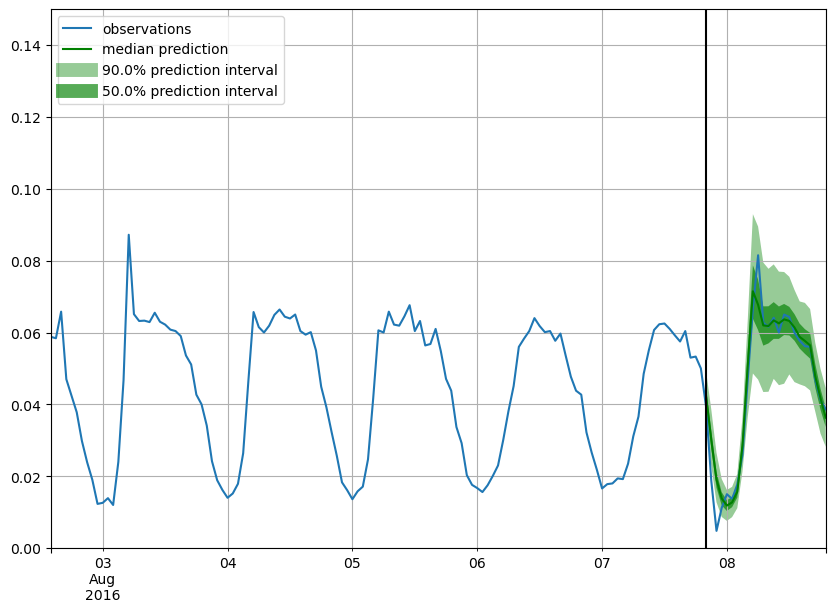

In [49]:
ts_entry = ts_li[0]
forecast_entry = forecast_li[0]
plot_prob_forecasts(ts_entry, forecast_entry, ylim=(0, 0.15))

In [43]:
_, ts_it_int = make_evaluation_predictions(
        dataset=dataset_intervened,  # test dataset
        predictor=predictor,  # predictor
        num_samples=NUM_SAMPLES,
    )
forecast_it_int = predictor.predict(dataset_intervened, num_samples=NUM_SAMPLES)
ts_li_int = list(ts_it_int)
forecast_li_int = list(forecast_it_int)
ts_entry_int = ts_li_int[0]
forecast_entry_int = forecast_li_int[0]

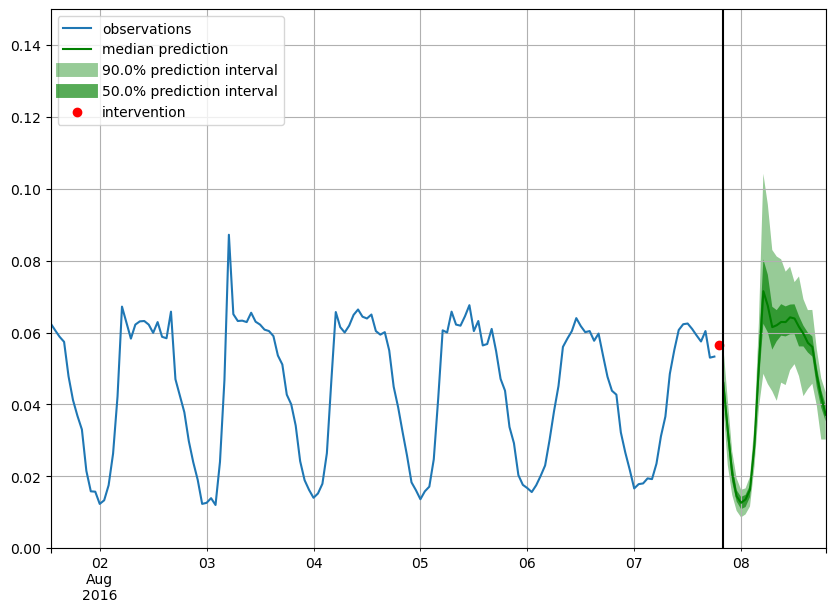

In [47]:
plot_prob_forecasts(ts_entry[:-predictor.prediction_length-WINDOW], forecast_entry_int, ts_entry_int, ylim=(0, 0.15))

In [45]:
dataset_intervened_across = create_interventional_dataset(
            dataset.test, predictor.prediction_length, feature_name=None, window=WINDOW)
_, ts_it_int_across = make_evaluation_predictions(
        dataset=dataset_intervened_across,  # test dataset
        predictor=predictor,  # predictor
        num_samples=NUM_SAMPLES,
    )
forecast_it_int_across = predictor.predict(dataset_intervened_across, num_samples=NUM_SAMPLES)
ts_li_int_across = list(ts_it_int_across)
forecast_li_int_across = list(forecast_it_int_across)

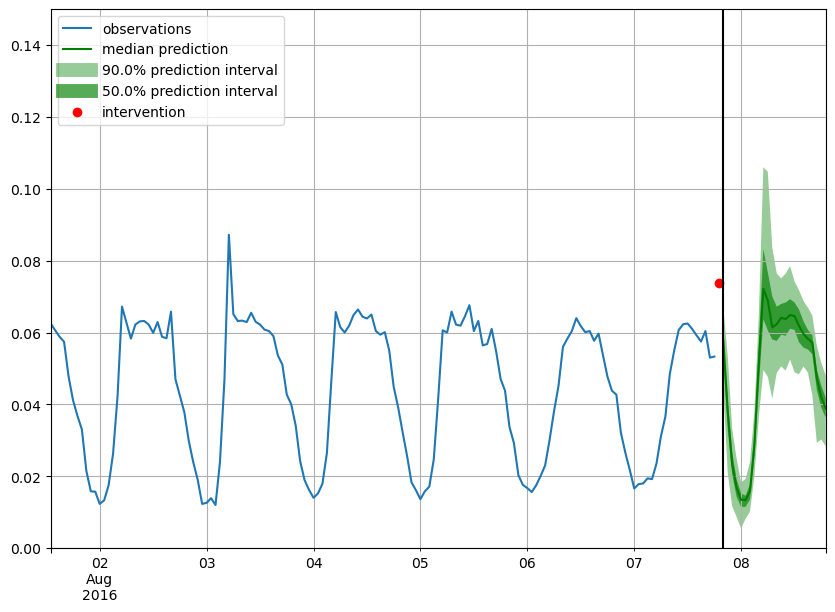

In [48]:
ts_entry_int_across = ts_li_int_across[0]
forecast_entry_int_across = forecast_li_int_across[0]
plot_prob_forecasts(ts_entry[:-predictor.prediction_length-WINDOW], forecast_entry_int_across, ts_entry_int_across, ylim=(0, 0.15))

In [50]:
predictor2 = estimator.train(dataset.train)

100%|██████████| 50/50 [00:06<00:00,  7.41it/s, epoch=26/100, avg_epoch_loss=-3.5]

Early stopping based on learning rate scheduler callback (min_lr was reached).


In [52]:
forecast_it2, ts_it2 = make_evaluation_predictions(
        dataset=dataset.test,  # test dataset
        predictor=predictor2,  # predictor
        num_samples=NUM_SAMPLES,
    )
forecast_li2 = list(forecast_it2)
ts_li2 = list(ts_it2)

In [76]:
_, ts_it_int_across2 = make_evaluation_predictions(
        dataset=dataset_intervened_across,  # test dataset
        predictor=predictor2,  # predictor
        num_samples=1,
    )

In [56]:
forecast_it_int_across2 = predictor2.predict(dataset_intervened_across, num_samples=NUM_SAMPLES)
forecast_li_int_across2 = list(forecast_it_int_across2)

In [77]:
ts_li_int_across2 = list(ts_it_int_across2)

In [78]:
ts_li_int_across2

[                          0
 2015-01-01 00:00:00  0.0048
 2015-01-01 01:00:00  0.0072
 2015-01-01 02:00:00  0.0040
 2015-01-01 03:00:00  0.0039
 2015-01-01 04:00:00  0.0042
 ...                     ...
 2016-08-07 15:00:00  0.0575
 2016-08-07 16:00:00  0.0604
 2016-08-07 17:00:00  0.0530
 2016-08-07 18:00:00  0.0533
 2016-08-07 19:00:00  0.0739
 
 [14036 rows x 1 columns],
                           0
 2015-01-01 00:00:00  0.0146
 2015-01-01 01:00:00  0.0148
 2015-01-01 02:00:00  0.0101
 2015-01-01 03:00:00  0.0060
 2015-01-01 04:00:00  0.0055
 ...                     ...
 2016-08-07 15:00:00  0.0491
 2016-08-07 16:00:00  0.0465
 2016-08-07 17:00:00  0.0432
 2016-08-07 18:00:00  0.0400
 2016-08-07 19:00:00  0.0542
 
 [14036 rows x 1 columns],
                           0
 2015-01-01 00:00:00  0.0289
 2015-01-01 01:00:00  0.0350
 2015-01-01 02:00:00  0.0267
 2015-01-01 03:00:00  0.0218
 2015-01-01 04:00:00  0.0191
 ...                     ...
 2016-08-07 15:00:00  0.2125
 2016-08-07 16

In [57]:
forecast_it_int = predictor.predict(dataset_intervened, num_samples=NUM_SAMPLES)

In [118]:
def plot_mean(ts, color, marker, label="mean"):
    pd.Series(data=ts.mean, index=ts.index).plot(
        color=color,
        marker=marker,
        ls=":",
        label=label
    )
    
markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
colors = ['r','g','b','c','m', 'y', 'k']

def plot_prob_forecasts_multiple(ts_entry, forecast_entry1,  forecast_entry2, ts_entry_intervention=None, window=WINDOW, ylim=None, plot_length=50):
    prediction_intervals = ()
    legend = ["observations"] + ["mean prediction model 1"] + ["mean prediction model 2"] 

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ax.set_ylim(ylim)
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    
    plot_mean(forecast_entry1, color="g", marker=".")
    plot_mean(forecast_entry2, color="b", marker="o")
    
    if ts_entry_intervention is not None:
        ts_entry_intervention[-window:].plot(ax=ax, style='ro') 
        legend += ['intervention']
        
    plt.axvline(forecast_entry.index[0], color='black') # end of input to prediction
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

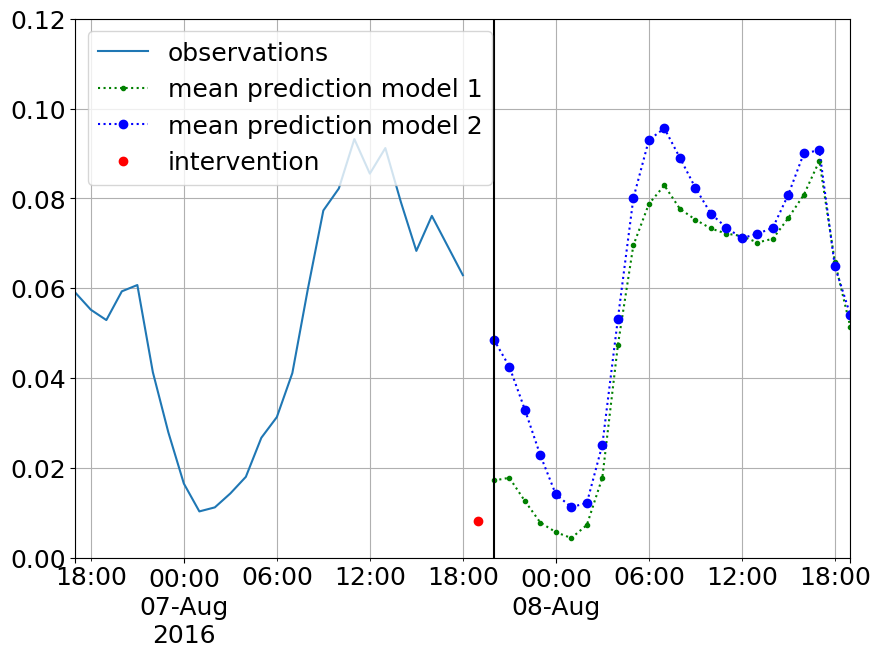

In [133]:
## 

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# not bad IDX = 6, 12
IDX = 12

plot_length = 50
plot_length_ts = plot_length - len(forecast_entry.samples[0])

ts_entry_int_across = ts_li_int_across[IDX]
forecast_entry_int_across = forecast_li_int_across[IDX]

forecast_entry_int_across2 = forecast_li_int_across2[IDX]
ts_entry_int_across2 = ts_li_int_across2[IDX]

plot_prob_forecasts_multiple(
    ts_entry[:-predictor.prediction_length-WINDOW], forecast_entry_int_across, forecast_entry_int_across2,
    ts_entry_int_across2, ylim=(0,0.12), plot_length=plot_length_ts)




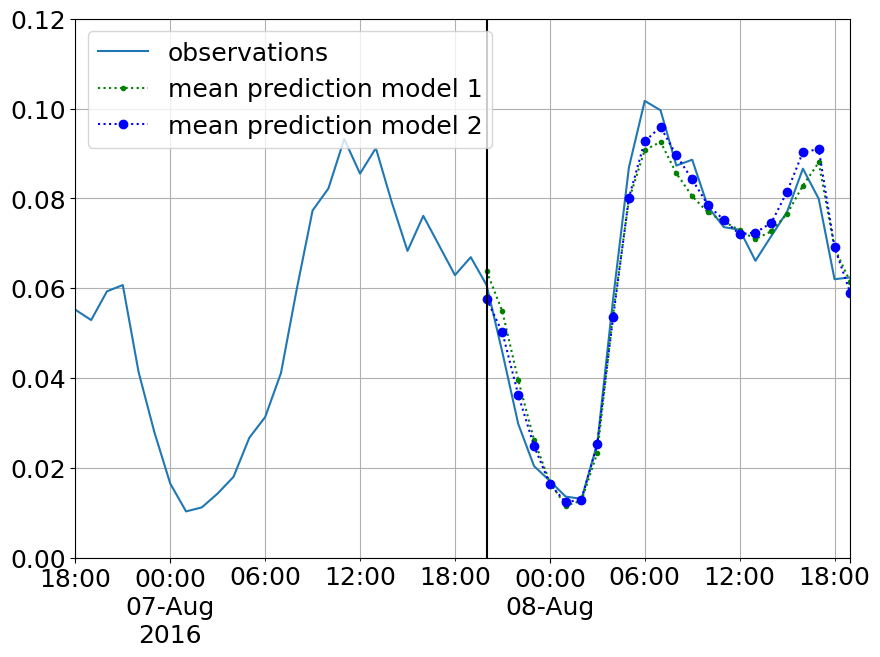

In [136]:
ts_entry = ts_li[IDX]
forecast_entry = forecast_li[IDX]

ts_entry2 = ts_li2[IDX]
forecast_entry2 = forecast_li2[IDX]

plot_prob_forecasts_multiple(ts_entry, forecast_entry, forecast_entry2, ylim=(0,0.12), plot_length=plot_length)